> ## Update
> - 使用病人编号数据进行生存分析



## 1. 数据预处理

### 1.1 数据加载

In [1]:
import pandas as pd
import numpy as np

# 选取 gene_expression, DNA methylation(450k), miRNA expression 数据
gene_expression_raw_data = pd.read_csv('data/gene_expression/batch_effects_normalized_mRNA_data', sep='\t', index_col=0, nrows=2000)
dna_methylation_450k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_450k', sep='\t', index_col=0, nrows=3000)
miRNA_expression_raw_data = pd.read_csv('data/miRNA_expression/batch_effects_normalized_miRNA_data', sep='\t', index_col=0, nrows=1000)


In [2]:
# 选取 clinical 数据
clinical_raw_data = pd.read_csv('data/clinical/phenotype_curated_clinical_data', sep='\t', index_col=0)

In [3]:
# 打印原始数据形状
gene_expression_raw_data.shape, dna_methylation_450k_raw_data.shape, miRNA_expression_raw_data.shape, clinical_raw_data.shape

((2000, 11069), (3000, 9664), (743, 10824), (12591, 33))

### 1.2 样本匹配

In [4]:
# 获取每个数据集的列名（样本 ID）
gene_expression_samples = set(gene_expression_raw_data.columns)
dna_methylation_samples = set(dna_methylation_450k_raw_data.columns)
miRNA_expression_samples = set(miRNA_expression_raw_data.columns)

# 找到所有数据集中共有的样本 ID
common_samples = gene_expression_samples & dna_methylation_samples & miRNA_expression_samples
common_samples = list(common_samples)

# 使用共有的样本 ID 来过滤每个数据集
gene_expression_data_filtered = gene_expression_raw_data[common_samples]
dna_methylation_data_filtered = dna_methylation_450k_raw_data[common_samples]
miRNA_expression_data_filtered = miRNA_expression_raw_data[common_samples]

In [71]:
# 查看过滤后的数据集形状
gene_expression_data_filtered.shape, dna_methylation_data_filtered.shape, miRNA_expression_data_filtered.shape

((2000, 8959), (3000, 8959), (743, 8959))

### 1.3 数据清洗

In [6]:
# 定义清理函数
def clean_data(data):
    data = data.dropna(axis=1, thresh=0.7*data.shape[0])
    data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
    data = data.fillna(0)
    return data

# 清理每种数据
gene_expression_data_cleaned = clean_data(gene_expression_data_filtered)
dna_methylation_data_cleaned = clean_data(dna_methylation_data_filtered)
miRNA_expression_data_cleaned = clean_data(miRNA_expression_data_filtered)

In [72]:
# 检查是否包含NaN值
print("Gene Expression Data contains NaN:", gene_expression_data_cleaned.isnull().values.any())
print("DNA Methylation 450K Data contains NaN:", dna_methylation_data_cleaned.isnull().values.any())
print("miRNA Expression Data contains NaN:", miRNA_expression_data_cleaned.isnull().values.any())

Gene Expression Data contains NaN: False
DNA Methylation 450K Data contains NaN: False
miRNA Expression Data contains NaN: False


## 2. 数据整合


### 2.1 数据降维（全程使用 PCA）

标准化数据

In [8]:
from sklearn.preprocessing import StandardScaler

# 使用Z-score标准化
scaler = StandardScaler()

gene_expression_data_scaled = pd.DataFrame(scaler.fit_transform(gene_expression_data_cleaned), 
                                           index=gene_expression_data_cleaned.index, columns=gene_expression_data_cleaned.columns)
dna_methylation_data_scaled = pd.DataFrame(scaler.fit_transform(dna_methylation_data_cleaned), 
                                       index=dna_methylation_data_cleaned.index, columns=dna_methylation_data_cleaned.columns)
miRNA_expression_data_scaled = pd.DataFrame(scaler.fit_transform(miRNA_expression_data_cleaned), 
                                              index=miRNA_expression_data_cleaned.index, columns=miRNA_expression_data_cleaned.columns)


PCA 降维 + 拼接

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


def combine_datasets_pca(data, n_components_list):
    """
    对给定的数据集应用 PCA 降维，并将它们拼接成一个数据集，同时保留样本名称信息。
    
    参数:
    - data: list of DataFrame, 输入数据集列表，每个DataFrame的列为样本，行为特征
    - n_components_list: list, 每个数据集对应的 PCA 降维后的维数列表
    
    返回:
    - combined_data_df: DataFrame, 拼接后的降维数据，包含样本名称信息
    """
    pca_transformed_data = []
    for dataset, n_components in zip(data, n_components_list):
        pca = PCA(n_components=n_components)
        # 假设dataset是DataFrame，其列名为样本名称
        transformed = pca.fit_transform(dataset.T)
        # 将PCA变换后的数据转换为DataFrame，并使用原始数据集的列名（样本名称）作为索引
        transformed_df = pd.DataFrame(transformed, index=dataset.columns)
        pca_transformed_data.append(transformed_df)
    
    # 使用pd.concat而不是np.concatenate来拼接数据，以保留索引（样本名称）
    combined_data_df = pd.concat(pca_transformed_data, axis=1)
    
    return combined_data_df

In [82]:
# from combine_datasets.combine_datasets_pca import combine_datasets_pca

data = [gene_expression_data_scaled, dna_methylation_data_scaled, miRNA_expression_data_scaled]
n_components_list = [200, 200, 200]

combined_data = combine_datasets_pca(data=data, n_components_list=n_components_list)

In [83]:
# 查看拼接后的数据集维度, 检查是否包含NaN值
combined_data.shape, combined_data.isnull().values.any()

((8959, 600), False)

## 3. 聚类分析


### 3.1 评估方式一 (使用轮廓系数)

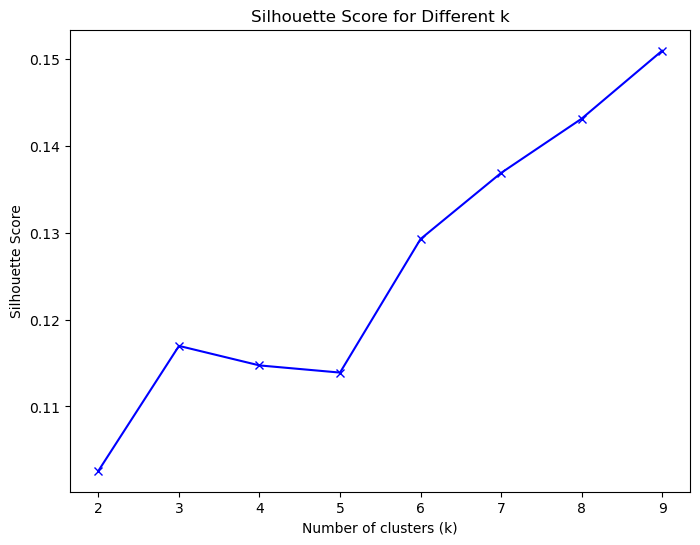

In [84]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 寻找最优的簇数量
silhouette_scores = []
K = range(2, 10)  # 我们尝试从2到10个簇
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(combined_data, labels)
    silhouette_scores.append(silhouette_avg)

# 可视化不同簇数量下的轮廓系数
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()


Best number of clusters: 9


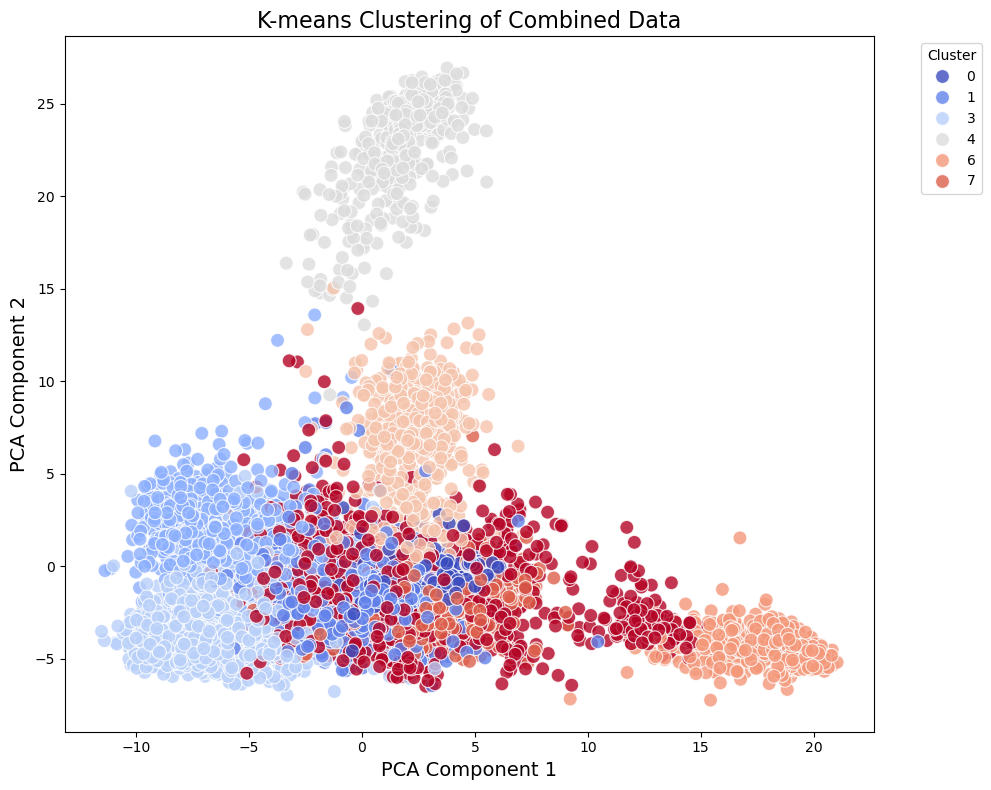

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选择最优簇数量并进行最终聚类
best_k = K[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

kmeans = KMeans(n_clusters=best_k)
kmeans.fit(combined_data)
labels = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(10, 8))  # 增大图形尺寸
sns.scatterplot(x=combined_data.iloc[:, 0], y=combined_data.iloc[:, 1], hue=labels,
                palette='coolwarm', s=100, edgecolor='w', alpha=0.8)  # 调整调色板，增加点的大小，添加点的边缘颜色
plt.title('K-means Clustering of Combined Data', fontsize=16)  # 增加标题字体大小
plt.xlabel('PCA Component 1', fontsize=14)  # 增加X轴标签字体大小
plt.ylabel('PCA Component 2', fontsize=14)  # 增加Y轴标签字体大小
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # 调整图例位置
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

### 3.2 评估方式二 (生存分析)

In [86]:
# 使用集合推导式提取前三个部分(提取出每个病人)并去除重复
common_patients = {'-'.join(sample.split('-')[:3]) for sample in common_samples}
clinical_patients = {'-'.join(sample.split('-')[:3]) for sample in clinical_raw_data.index}

# 筛选出病人数据
common_patients = common_patients & clinical_patients

# 将数据集病人和临床数据病人匹配
clinical_data_filtered = clinical_raw_data[clinical_raw_data['_PATIENT'].isin(common_patients)]
clinical_data = clinical_data_filtered.drop_duplicates(subset=['_PATIENT'])

combined_data['_PATIENT'] = combined_data.index.map(lambda x: '-'.join(x.split('-')[:3]))
combined_data_filtered = combined_data[combined_data['_PATIENT'].isin(common_patients)]
combined_data_filtered = combined_data_filtered.drop_duplicates(subset=['_PATIENT'])
combined_data = combined_data_filtered.drop(columns=['_PATIENT'])

In [87]:
# 将 clinical 数据中 OS.time 的NaN值替换为 last_contact_days_to 值
clinical_data.loc[:, 'OS.time'] = clinical_data['OS.time'].fillna(clinical_data['last_contact_days_to'])
clinical_data.loc[:, 'OS.time'] = clinical_data['OS.time'].fillna(clinical_data['OS.time'].mean())

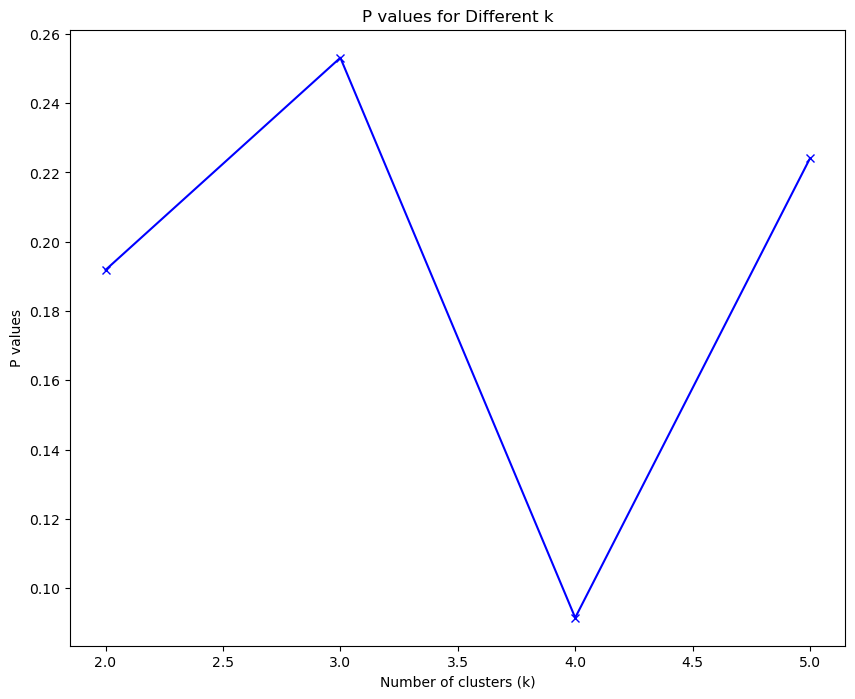

Optimal k: 4 with p-value: 0.09153613816221029


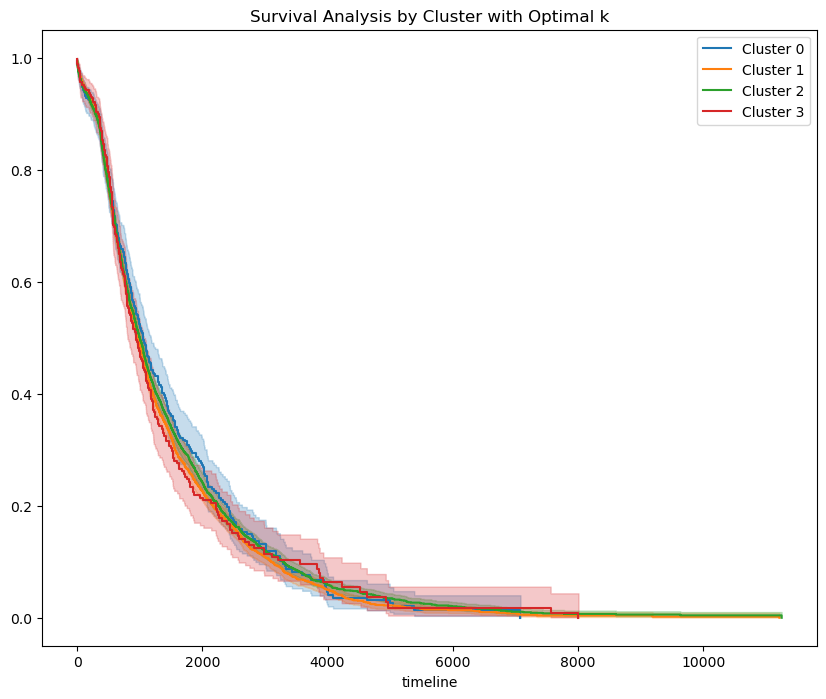

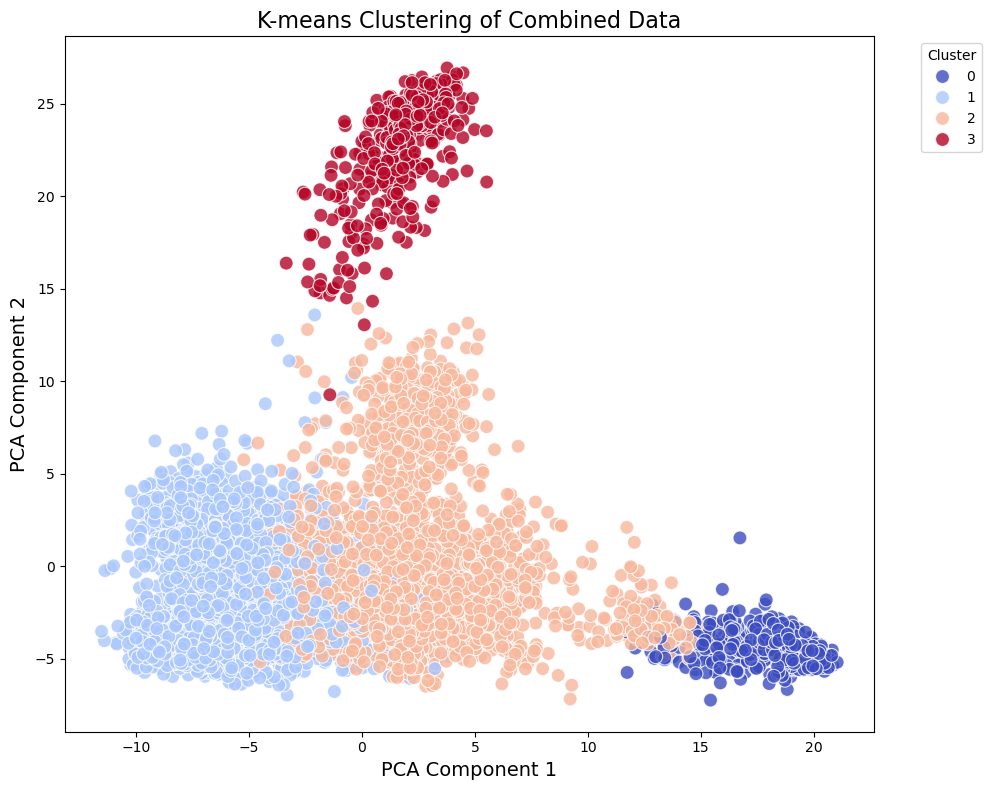

In [111]:
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k_and_plot(survival_data, combined_data, k_range):
    optimal_k = None
    best_p_value = 1  # 初始化为最大的p值
    best_labels = None
    total_p_values = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(combined_data)
        
        survival_data.loc[:, 'Cluster'] = labels
        kmf = KaplanMeierFitter()
        survival_curves = []

        for cluster in np.unique(labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E)
            survival_curves.append((T, E))
        
        # 计算不同聚类之间的生存曲线差异
        p_values = []
        for i in range(len(survival_curves) - 1):
            for j in range(i + 1, len(survival_curves)):
                result = logrank_test(survival_curves[i][0], survival_curves[j][0], event_observed_A=survival_curves[i][1], event_observed_B=survival_curves[j][1])
                p_values.append(result.p_value)
                
        # 选择差异最大（p值最小）的聚类结果
        min_p_value = np.min(p_values) if p_values else 1
        total_p_values.append(min_p_value)
        if min_p_value < best_p_value:
            best_p_value = min_p_value
            optimal_k = k
            best_labels = labels
            
    # 可视化不同簇数量下的轮廓系数
    plt.figure(figsize=(10, 8))  # 增大图形尺寸
    plt.plot(k_range, total_p_values, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('P values')
    plt.title('P values for Different k')
    plt.show()

    # 使用最优的k值进行聚类，并画出生存曲线图
    if optimal_k:
        print(f"Optimal k: {optimal_k} with p-value: {best_p_value}")
        survival_data.loc[:, 'Cluster'] = best_labels
        kmf = KaplanMeierFitter()

        plt.figure(figsize=(10, 8))  # 增大图形尺寸
        for cluster in np.unique(best_labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E, label=f'Cluster {cluster}')
            kmf.plot_survival_function()
        
        plt.title('Survival Analysis by Cluster with Optimal k')
        plt.show()
    else:
        print("No optimal k found.")
    
    # 可视化聚类结果
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(combined_data)
    plt.figure(figsize=(10, 8))  # 增大图形尺寸
    sns.scatterplot(x=combined_data.iloc[:, 0], y=combined_data.iloc[:, 1], hue=labels,
                    palette='coolwarm', s=100, edgecolor='w', alpha=0.8)  # 调整调色板，增加点的大小，添加点的边缘颜色
    plt.title('K-means Clustering of Combined Data', fontsize=16)  # 增加标题字体大小
    plt.xlabel('PCA Component 1', fontsize=14)  # 增加X轴标签字体大小
    plt.ylabel('PCA Component 2', fontsize=14)  # 增加Y轴标签字体大小
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # 调整图例位置
    plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
    plt.show()


find_optimal_k_and_plot(clinical_data, combined_data, range(2, 6))